In [1]:
import pytz, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, matplotlib.patches as mpatches
from datetime import date, datetime, timedelta
from matplotlib.colors import to_rgba
from scipy.stats import ks_2samp, mannwhitneyu, shapiro, ttest_ind
sns.set_theme(style="ticks")
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial:italic'

# parameter

In [2]:
yeari, yearf = '2024', '2024'
weeki, weekf = '18', '31'

In [3]:
di = datetime.strptime(f'{yeari}-{weeki}-1', "%Y-%W-%w").date()
df = datetime.strptime(f'{yearf}-{weekf}-1', "%Y-%W-%w").date() + timedelta(6)
ds = [di+timedelta(dt) for dt in range((df-di).days+1)]
daylist = ds
print(di, 'until', df)

2024-04-29 until 2024-08-04


In [4]:
cdef = 'tl7_10m'# 'tl5_10m' 'tl6_10m' 'tl7_10m' 'tl8_10m' 'tl8_60m'
cdef_alt = '16m_10min'# tl5: 62 ... tl7: 16   tl8: 8

# load data

In [5]:
# load EURO 2024 match data
combined_df = pd.read_csv('data/metadata/euro2024_match_data.csv')
combined_df['day'] = [d.date() for d in pd.to_datetime(combined_df.day)]

In [6]:
# load event data
df_events = pd.read_csv('data/metadata/event_data.csv')
df_events = df_events[['city','day','match']]
df_events['day'] = [d.date() for d in pd.to_datetime(df_events.day)]

# analyses

In [10]:
data = pd.read_csv('data/fig4/contacts_cities_stadiums.csv')
data['day'] = [d.date() for d in pd.to_datetime(data.day)]
data['stime'] = pd.to_datetime(data.stime)
data['hour'] = data.stime.dt.hour

In [11]:
for_heatmap = data.groupby(['city','day','hour']).pair.apply(lambda x: len(set(x))).reset_index()
c1 = pd.DataFrame(set(for_heatmap.city), columns=['city'])
c3 = pd.DataFrame([d.date() for d in pd.date_range(di, df)], columns=['day'])
c4 = pd.DataFrame(list(range(24)), columns=['hour'])
for_heatmap = c1.merge(c3, how='cross').merge(c4, how='cross').merge(for_heatmap, on=['city','day','hour'], how='left')
for_heatmap

,city,day,hour,pair
0,Hamburg,2024-04-29,0,NaN
1,Hamburg,2024-04-29,1,NaN
2,Hamburg,2024-04-29,2,3.0
3,Hamburg,2024-04-29,3,1.0
4,Hamburg,2024-04-29,4,4.0
...,...,...,...,...
23515,Stuttgart,2024-08-04,19,6.0
23516,Stuttgart,2024-08-04,20,4.0
23517,Stuttgart,2024-08-04,21,2.0
23518,Stuttgart,2024-08-04,22,4.0


In [12]:
10*98*24

23520

In [13]:
# execute if using non-event baseline (instead of non-Germany match baseline)
dbase = pd.DataFrame(pd.date_range(date(2024,6,10), date(2024,8,4)), columns=['day'])
dbase['day'] = dbase.day.apply(lambda x: x.date())
dbase = dbase.merge(pd.DataFrame(list(set(for_heatmap.city)), columns=['city']), how='cross')
dbase = dbase.merge(df_events, on=['day','city'], how='left')
dbase = dbase[dbase.match.isna()].drop(columns='match')
dbase['wd'] = dbase.day.apply(lambda x: x.weekday())

combined_df = combined_df[combined_df.match.apply(lambda x: 'Germany' in x)].copy(deep=True)
combined_df_base = combined_df.copy(deep=True)
combined_df_base['wd'] = combined_df_base.day.apply(lambda x: x.weekday())
combined_df_base = combined_df_base.drop(columns=['day','match']).merge(dbase, on=['city','wd'])
combined_df_base['match'] = 'base'
combined_df_base = combined_df_base.drop(columns=['wd'])
combined_df = pd.concat([combined_df, combined_df_base])
combined_df

,city,day,hour_match,match
0,München,2024-06-14,21,Germany 5 - 1 Scotland
2,Stuttgart,2024-06-19,18,Germany 2 - 0 Hungary
4,Frankfurt am Main,2024-06-23,21,Switzerland 1 - 1 Germany
36,Dortmund,2024-06-29,21,Germany 2 - 0 Denmark
44,Stuttgart,2024-07-05,18,Spain 2 - 1 Germany
0,München,2024-06-21,21,base
1,München,2024-06-28,21,base
2,München,2024-07-12,21,base
3,München,2024-07-19,21,base
4,München,2024-07-26,21,base


In [14]:
print((combined_df.match!='base').sum(), (combined_df.match=='base').sum())

5 27


In [12]:
# execute if using non-Germany match baseline
# count the contacts by city, day and hour and join them on the match metadata by city and day
combined_df2 = combined_df.merge(for_heatmap.groupby(['city','day','hour']).pair.sum().reset_index(), on=['city','day'])
combined_df_next = combined_df.copy(deep=True)
combined_df_next['day'] = combined_df_next.day - timedelta(1)
combined_df3 = combined_df_next.merge(for_heatmap.groupby(['city','day','hour']).pair.sum().reset_index(), on=['city','day'])
combined_df3['hour'] = combined_df3.hour + 24
combined_df2 = pd.concat([combined_df2, combined_df3])
# define a time relative to start of the match
combined_df2['hour_rel'] = combined_df2.hour - combined_df2.hour_match
# define a flag on whether the match involved Germany
combined_df2['germany'] = combined_df2.match.apply(lambda x: 'Germany' in x)
combined_df2

,city,day,hour_match,match,hour,pair,hour_rel,germany
0,München,2024-06-14,21,Germany 5 - 1 Scotland,0,1.0,-21,True
1,München,2024-06-14,21,Germany 5 - 1 Scotland,1,2.0,-20,True
2,München,2024-06-14,21,Germany 5 - 1 Scotland,2,0.0,-19,True
3,München,2024-06-14,21,Germany 5 - 1 Scotland,3,0.0,-18,True
4,München,2024-06-14,21,Germany 5 - 1 Scotland,4,1.0,-17,True
...,...,...,...,...,...,...,...,...
763,Stuttgart,2024-08-01,18,base,43,9.0,25,False
764,Stuttgart,2024-08-01,18,base,44,6.0,26,False
765,Stuttgart,2024-08-01,18,base,45,3.0,27,False
766,Stuttgart,2024-08-01,18,base,46,3.0,28,False


In [13]:
# compute baseline as total contact number in a given city on a given day
sumtoone = False#True#False
if sumtoone:
    baseline = combined_df2.groupby(['city','day']).pair.apply(np.sum).reset_index().rename(columns={'pair':'baseline'})
else:
    hour_min = [-5]
    baseline = combined_df2[(combined_df2.hour_rel.isin(hour_min)) & (combined_df2.match.apply(lambda x: 'Germany' not in x))].groupby(['city']).pair.apply(np.median).reset_index().rename(columns={'pair':'baseline'})
baseline

,city,baseline
0,Dortmund,25.0
1,Frankfurt am Main,15.5
2,München,15.0
3,Stuttgart,15.0


In [14]:
# compute hourly share of contacts over the day
if sumtoone:
    combined_df_tobase = combined_df2.merge(baseline, on=['city','day'])
else:
    combined_df_tobase = combined_df2.merge(baseline, on=['city'])
combined_df_tobase['normed'] = combined_df_tobase.pair / combined_df_tobase.baseline

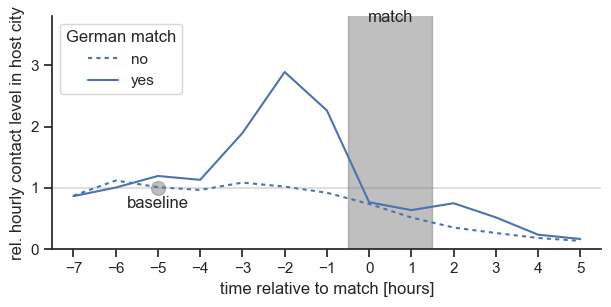

In [15]:
sns.set_theme(style="ticks")

g = sns.relplot(
    data=combined_df_tobase[(combined_df_tobase.hour_rel>=-7) & (combined_df_tobase.hour_rel<=5)].groupby(['hour_rel','germany']).normed.mean().reset_index(),
    x="hour_rel", y="normed",
    hue="germany",# size="choice", col="align",
    kind="line", palette=[to_rgba('C0', alpha=1.), 'C0'], hue_order=[False, True],# size_order=["T1", "T2"],
    style="germany", dashes={False: (2,2), True: ''},
    height=3.2, aspect=2, facet_kws=dict(sharex=False),
)

# Plot the orbital period with horizontal boxes
yup = 1.1*combined_df_tobase.normed.max()#.225#.26
g.ax.fill_between([-.5,1.5], [yup,yup], color='gray', zorder=0, alpha=.5)
g.ax.text(.5, .7*yup-.02, 'match', ha='center', va='center')
g.ax.scatter([-5], [1], c='gray', s=100, alpha=.5)
g.ax.set_xticks(range(-7,5+1))
if sumtoone:
    g.ax.set_yticks(np.arange(0,.2+1e-10,.05))
g.ax.set_ylim([0,.7*yup])
g.ax.set_xlabel("time relative to match [hours]")
g.ax.set_ylabel("hourly contact share in host city")
if sumtoone:
    g.ax.set_ylabel("hourly contact share in host city")
else:
    g.ax.set_ylabel("rel. hourly contact level in host city")
    g.ax.text(-5, .75, 'baseline', ha='center', va='center')
if not sumtoone:
    xu, xo = -7.5, 5.5
    g.ax.plot([xu, xo], [1,1], c='gray', alpha=.25)
    g.ax.set_xlim([xu, xo])

g._legend.remove()
lg = g.ax.legend(loc='upper left')
lg.set_title('German match')#lg.set_title('German match')
new_labels = ["no", "yes"]
for text, new_label in zip(lg.texts, new_labels):
    text.set_text(new_label)

plt.savefig(f'plots/fig4/contacts_around_euro24_matches_sumtoone{sumtoone}_line.jpg', bbox_inches='tight', dpi=300)
plt.savefig(f'plots/fig4/contacts_around_euro24_matches_sumtoone{sumtoone}_line.pdf', bbox_inches='tight')
plt.show()

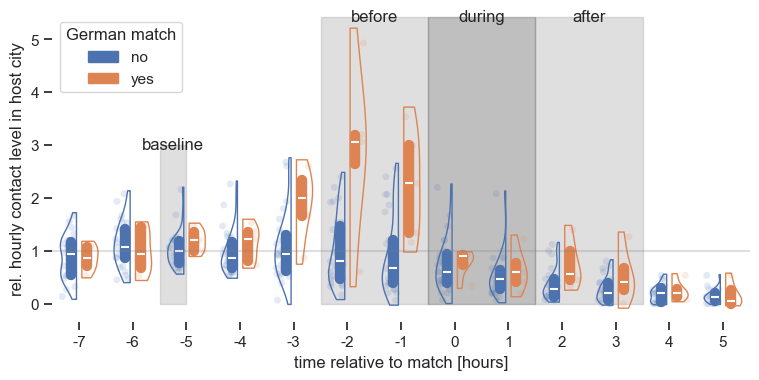

In [16]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(9, 4))
#ax.set_xscale("log")

yup = 1.1*combined_df_tobase.normed.max()#.26
ax.fill_between([4.5,6.5], [yup,yup], color='gray', zorder=0, alpha=.25)
ax.fill_between([6.5,8.5], [yup,yup], color='gray', zorder=0, alpha=.5)
ax.fill_between([8.5,10.5], [yup,yup], color='gray', zorder=0, alpha=.25)
ax.text(5.5, yup, 'before', ha='center', va='center')
ax.text(7.5, yup, 'during', ha='center', va='center')
ax.text(9.5, yup, 'after', ha='center', va='center')
if not sumtoone:
    ax.fill_between([-.5+min(hour_min)+7,0.+min(hour_min)+7], [yup,yup] if sumtoone else [3,3], color='gray', zorder=0, alpha=.25)
    ax.text(-.25+min(hour_min)+7, .95*yup if sumtoone else 3, 'baseline', ha='center', va='center')

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=combined_df_tobase[(combined_df_tobase.hour_rel>=-7) & (combined_df_tobase.hour_rel<=5)],
               x="hour_rel", y="normed", hue="germany",
               split=True, bw_adjust=1, cut=.25, linewidth=1, palette=sns.color_palette(None, 2),
               fill=False, inner='box', gap=.25, density_norm='width',
               inner_kws=dict(box_width=7.5, whis_width=0)
              )
# Add in points to show each observation
# Show each observation with a scatterplot
sns.stripplot(
    data=combined_df_tobase[(combined_df_tobase.hour_rel>=-7) & (combined_df_tobase.hour_rel<=5)],
    x="hour_rel", y="normed", hue="germany", palette=sns.color_palette(None, 2),#['k','k'],
    dodge=True, alpha=.15, zorder=1, legend=False, jitter=.25,
)

# Tweak the visual presentation
ax.yaxis.grid(True)
ax.set(xlabel="time relative to match [hours]")
if sumtoone:
    ax.set(ylabel="hourly contact share in host city")
else:
    ax.set(ylabel="rel. hourly contact level in host city")
ax.set_xlim(-.5, 12.5)
ax.grid(False)
sns.despine(trim=True, bottom=True, left=True)

if not sumtoone:
    ax.plot([-.5, 12.5], [1,1], c='gray', alpha=.25)

# Get the legend object
#legend = ax.get_legend()
handles = [mpatches.Patch(color=c) for c in sns.color_palette(None, 2)]
legend = ax.legend(handles=handles, labels=["no", "yes"], title="German match", loc='upper left')

plt.savefig(f'plots/fig4/contacts_around_euro24_matches_sumtoone{sumtoone}.jpg', bbox_inches='tight', dpi=300)
plt.savefig(f'plots/fig4/contacts_around_euro24_matches_sumtoone{sumtoone}.pdf', bbox_inches='tight')
plt.show()

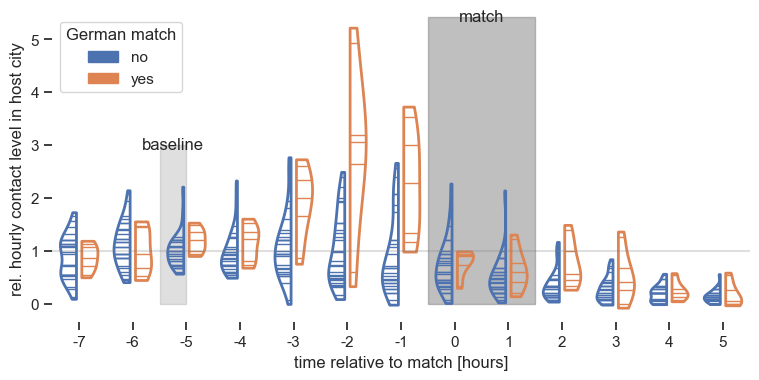

In [17]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(9, 4))
#ax.set_xscale("log")

yup = 1.1*combined_df_tobase.normed.max()#.26
#ax.fill_between([4.5,6.5], [yup,yup], color='gray', zorder=0, alpha=.25)
ax.fill_between([6.5,8.5], [yup,yup], color='gray', zorder=0, alpha=.5)
#ax.fill_between([8.5,10.5], [yup,yup], color='gray', zorder=0, alpha=.25)
#ax.text(5.5, yup, 'before', ha='center', va='center')
ax.text(7.5, yup, 'match', ha='center', va='center')#'during'
#ax.text(9.5, yup, 'after', ha='center', va='center')
if not sumtoone:
    ax.fill_between([-.5+min(hour_min)+7,0.+min(hour_min)+7], [yup,yup] if sumtoone else [3,3], color='gray', zorder=0, alpha=.25)
    ax.text(-.25+min(hour_min)+7, .95*yup if sumtoone else 3, 'baseline', ha='center', va='center')

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=combined_df_tobase[(combined_df_tobase.hour_rel>=-7) & (combined_df_tobase.hour_rel<=5)],
               x="hour_rel", y="normed", hue="germany",
               split=True, bw_adjust=1, cut=.25, linewidth=2, palette=sns.color_palette(None, 2),
               fill=False, inner='stick', gap=.25, density_norm='width',
               #inner_kws=dict(box_width=7.5, whis_width=0)
              )
# Add in points to show each observation
# Show each observation with a scatterplot
#sns.stripplot(
#    data=combined_df_tobase[(combined_df_tobase.hour_rel>=-7) & (combined_df_tobase.hour_rel<=5)],
#    x="hour_rel", y="normed", hue="germany", palette=sns.color_palette(None, 2),#['k','k'],
#    dodge=True, alpha=.15, zorder=1, legend=False, jitter=.25,
#)

# Tweak the visual presentation
ax.yaxis.grid(True)
ax.set(xlabel="time relative to match [hours]")
if sumtoone:
    ax.set(ylabel="hourly contact share in host city")
else:
    ax.set(ylabel="rel. hourly contact level in host city")
ax.set_xlim(-.5, 12.5)
ax.grid(False)
sns.despine(trim=True, bottom=True, left=True)

if not sumtoone:
    ax.plot([-.5, 12.5], [1,1], c='gray', alpha=.25)

# Get the legend object
#legend = ax.get_legend()
handles = [mpatches.Patch(color=c) for c in sns.color_palette(None, 2)]
legend = ax.legend(handles=handles, labels=["no", "yes"], title="German match", loc='upper left')

plt.savefig(f'plots/fig4/contacts_around_euro24_matches_sumtoone{sumtoone}_simple.jpg', bbox_inches='tight', dpi=300)
plt.savefig(f'plots/fig4/contacts_around_euro24_matches_sumtoone{sumtoone}_simple.pdf', bbox_inches='tight')
plt.show()

In [28]:
combined_df_tobase.baseline.apply(lambda x: 1./x)

0       0.066667
1       0.066667
2       0.066667
3       0.066667
4       0.066667
          ...   
1531    0.040000
1532    0.040000
1533    0.040000
1534    0.040000
1535    0.040000
Name: baseline, Length: 1536, dtype: float64

-7 Median ratio: -0.071 95% CI: (-0.449, 1.025)
-6 Median ratio: -0.125 95% CI: (-0.524, 0.543)
-5 Median ratio: 0.200 95% CI: (-0.067, 0.615)
-4 Median ratio: 0.414 95% CI: (-0.203, 0.855)
-3 Median ratio: 1.143 95% CI: (-0.071, 2.182)
-2 Median ratio: 2.833 95% CI: (-0.250, 5.668)
-1 Median ratio: 2.420 95% CI: (0.250, 5.818)
0 Median ratio: 0.505 95% CI: (-0.444, 1.053)
1 Median ratio: 0.286 95% CI: (-0.571, 2.065)
2 Median ratio: 1.100 95% CI: (0.033, 5.250)
3 Median ratio: 1.000 95% CI: (-1.000, 6.917)


C:\Users\steven.schulz\AppData\Local\Temp\ipykernel_9584\4277500251.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = np.median(sample2) / np.median(sample1) -1. # (np.median(sample1)+np.median(pseudocnt)) -1.


4 Median ratio: 0.000 95% CI: (-0.667, 3.000)


C:\Users\steven.schulz\AppData\Local\Temp\ipykernel_9584\4277500251.py:19: RuntimeWarning: invalid value encountered in scalar divide
  ratio = np.median(sample2) / np.median(sample1) -1. # (np.median(sample1)+np.median(pseudocnt)) -1.


5 Median ratio: -0.690 95% CI: (nan, nan)


In [31]:
for_test = combined_df_tobase[(combined_df_tobase.hour_rel>=-7) & (combined_df_tobase.hour_rel<=5)][['hour_rel','city','germany','normed']]
for_test

,hour_rel,city,germany,normed
14,-7,München,True,0.533333
15,-6,München,True,0.666667
16,-5,München,True,1.000000
17,-4,München,True,0.733333
18,-3,München,True,0.866667
...,...,...,...,...
1489,4,Dortmund,False,0.200000
1490,5,Dortmund,False,0.160000
1512,3,Dortmund,False,0.080000
1513,4,Dortmund,False,0.040000


In [34]:
for_df = []
h_significant = []
for h in sorted(list(set(for_test.hour_rel))):
    data1 = for_test[(for_test.germany==False) & (for_test.hour_rel==h)].normed.tolist()
    data2 = for_test[(for_test.germany==True) & (for_test.hour_rel==h)].normed.tolist()

    statistic, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
    #statistic, p_value = ks_2samp(data1, data2)
    #statistic, p_value = ttest_ind(data1, data2, equal_var=False)# equal_var=False corresponds to Welch's t-test
    #print(f"Mann–Whitney U statistic: {statistic}, p-value: {p_value:.4f}")
    print(h, p_value, len(data1), len(data2))
    for_df.append(p_value)
    if p_value < .05:
        h_significant.append(h)
print(h_significant)

-7 0.9792151988182495 27 5
-6 0.6586062310541196 27 5
-5 0.11217574293263363 27 5
-4 0.252840875162346 27 5
-3 0.03537240612064047 27 5
-2 0.00875625240210742 27 5
-1 0.0080885013568304 27 5
0 0.6033958876270125 27 5
1 0.39084796595435123 27 5
2 0.02532454682477091 27 5
3 0.27430177704807013 27 5
4 0.6008099657108252 27 5
5 0.7529411135973223 27 5
[-3, -2, -1, 2]


In [37]:
for hour_rel in h_significant:#range(-7, 5+1):
    np.random.seed(42)

    # Sample data
    group1 = combined_df_tobase[(combined_df_tobase.hour_rel==hour_rel) & (combined_df_tobase.germany==False)].normed.tolist()
    group2 = combined_df_tobase[(combined_df_tobase.hour_rel==hour_rel) & (combined_df_tobase.germany==True)].normed.tolist()
    #pseudocnt = combined_df_tobase[(combined_df_tobase.hour_rel==hour_rel) & (combined_df_tobase.germany==True)].baseline.apply(lambda x: 1./x).tolist()
     
    # Compute observed median difference
    median_ratio = np.median(group2) / np.median(group1) -1. # (np.median(group1)+np.median(pseudocnt)) -1.
     
    # Bootstrapping
    n_iterations = 10000
    bootstrap_ratios = []
     
    for _ in range(n_iterations):
        sample1 = np.random.choice(group1, size=len(group1), replace=True)
        sample2 = np.random.choice(group2, size=len(group2), replace=True)
        ratio = np.median(sample2) / np.median(sample1) -1. # (np.median(sample1)+np.median(pseudocnt)) -1.
        bootstrap_ratios.append(ratio)
     
    # Compute 95% confidence interval (2.5th and 97.5th percentiles)
    ci_lower = np.percentile(bootstrap_ratios, 2.5)
    ci_upper = np.percentile(bootstrap_ratios, 97.5)
     
    print(hour_rel, f"Median ratio: {(100*median_ratio):.1f}%", f"95% CI: ({(100*ci_lower):.1f}%, {(100*ci_upper):.1f}%)")

-3 Median ratio: 114.3% 95% CI: (-13.3%, 218.2%)
-2 Median ratio: 283.3% 95% CI: (-38.0%, 572.7%)
-1 Median ratio: 242.0% 95% CI: (25.0%, 564.3%)
2 Median ratio: 110.0% 95% CI: (3.3%, 525.0%)
